# 题目要求

用机器学习方法揭秘泰坦尼克号生存的奥秘：

泰坦尼克号事件时20世纪最著名的海难之一。1912年4月15日，泰坦尼克号在首次航行时与一座冰山相撞，导致超过1500人死亡。这场灾难震惊了全世界，引起了人们对航海安全的广泛关注。为了探究乘客的个人特征（性别、年龄、船舱等级等）与生存情况之间的关系，请构建一个机器学习模型，用机器学习模型揭秘生存奥秘。

要求如下：

1.读取数据，对数据进行清洗
2.将数据划分为训练集和测试集
3.训练机器学习算法（决策树或随机森林）
4.检验机器学习模型分类的性能


In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [13]:
# 读取数据
df = pd.read_csv('titanicDeath.csv', usecols=[1, 2, 4, 5])
df.replace({'性别': {'male': 1, 'female': 0}}, inplace=True)  # 设置性别为0和1
df = df.dropna()  # 删除包含NaN的行
df = np.array(df)
m, n = df.shape
# np.random.shuffle(df)
data_dev = df[0:200].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
datat = df[200:m].T
Yt = datat[0]
Xt = datat[1:n]


In [14]:
# 将数据转换为PyTorch张量
Xt_tensor = torch.tensor(Xt.T, dtype=torch.float32)
Yt_tensor = torch.tensor(Yt, dtype=torch.long)

In [15]:
# 构建自定义的神经网络模型
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(n-1, 30)
        self.fc2 = nn.Linear(30, 50)
        self.fc3 = nn.Linear(50, 80)
        self.fc4 = nn.Linear(80, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x


In [16]:
# 实例化模型、损失函数和优化器
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# 将数据包装成 DataLoader
dataset = TensorDataset(Xt_tensor, Yt_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# 训练模型
epochs = 600
losses, accuracies = [], []

In [17]:

for epoch in range(epochs):
    epoch_loss = 0.0
    correct = 0

    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(dataloader)
    accuracy = correct / len(dataset)
    losses.append(avg_loss)
    accuracies.append(accuracy)

    # if epoch % 10 == 0:
    #     print(f"Epoch: {epoch}, Loss: {avg_loss}, Accuracy: {accuracy}")


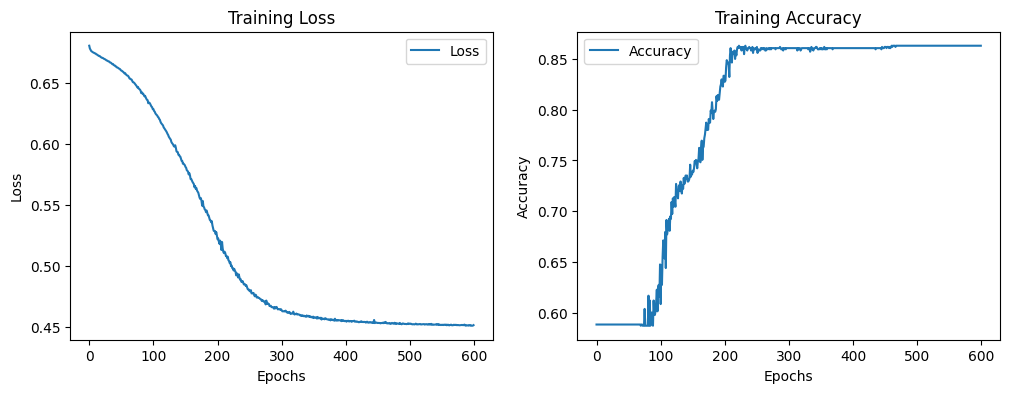

In [18]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [19]:
# Test the model
def test_model(model, test_data, test_labels):
    model.eval()
    with torch.no_grad():
        test_inputs = torch.tensor(test_data.T, dtype=torch.float32)
        test_labels = torch.tensor(test_labels, dtype=torch.long)
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == test_labels).sum().item() / len(test_labels)
        print(f"Test Accuracy: {accuracy}")

In [20]:
test_model(model, X_dev, Y_dev)


Test Accuracy: 0.81


In [21]:
torch.save(model, 'model.pkl') # 保存整个网络

In [22]:
ml = torch.load('model.pkl') # 加载整个网络

test_model(ml, X_dev, Y_dev)

Test Accuracy: 0.81
